In [2]:
import pandas as pandas
import numpy as np 
import jax.numpy as jnp
import jax.scipy.stats as jst
import jax
import scipy.stats as st
import matplotlib.pyplot as plt

In [3]:
def random_process(S0, r, sigma, T, total_granularity, sim_size):
    increments = st.norm.rvs(0, 1, size = (sim_size, total_granularity))
    increments = increments * sigma / jnp.sqrt(total_granularity / T) + (r - sigma ** 2 / 2) / (total_granularity / T)

    paths = S0 * jnp.exp(jnp.cumsum(increments, axis = 1))
    return paths

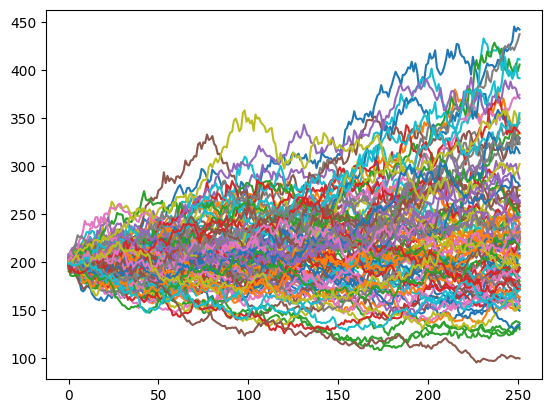

In [4]:
plt.plot(random_process(200, 0.1, 0.2, 2, 252, 100).T)
plt.show()

In [5]:
def european_call(S0, K, r, sigma, T, granularity = 252, sim_size = 100):
    paths = random_process(S0 = S0, r = r, sigma = sigma, T = T, total_granularity = granularity, sim_size = sim_size)
    PVs = jnp.fmax(paths[:, -1] - K, 0) / jnp.exp(r * T)
    return jnp.mean(PVs)

In [6]:
european_call(200., 230., 0.1, 0.2, 1, 252, 100000)

Array(12.564339, dtype=float32)

In [8]:
first_order_greeks = jax.grad(european_call, argnums = [0, 2, 3, 4])(200., 230., 0.1, 0.2, 1., 252, 100000)

print(f"Delta = {first_order_greeks[0]}")
print(f"DV01 = {first_order_greeks[1] * 0.0001}")
print(f"Vega = {first_order_greeks[2] / 100}")
print(f"Theta = {-first_order_greeks[3] / 252} per day")

Delta = 0.46076667308807373
DV01 = 0.007965093478560448
Vega = 0.7930223345756531
Theta = -0.06307666003704071 per day


In [9]:
jax.value_and_grad(european_call, argnums = [0, 2, 3, 4])(200., 230., 0.1, 0.2, 1., 252, 100000)

(Array(12.488361, dtype=float32),
 (Array(0.46090457, dtype=float32, weak_type=True),
  Array(79.69257, dtype=float32, weak_type=True),
  Array(79.2109, dtype=float32, weak_type=True),
  Array(15.890348, dtype=float32, weak_type=True)))

In [44]:
def asian_call_func(S0, K, r, sigma, T, granularity = 252, sim_size = 100):
    paths = random_process(S0 = S0, r = r, sigma = sigma, T = T, total_granularity = granularity, sim_size = sim_size)
    PVs = jnp.fmax(jnp.mean(paths, axis = 1) - K, 0) / jnp.exp(r * T)
    return jnp.mean(PVs)

In [45]:
res = jax.value_and_grad(asian_call_func, argnums = [0, 2, 3, 4])(200., 230., 0.1, 0.2, 1., 252, 100000)
PV = res[0]
Delta = res[1][0]
DV01 = res[1][1] * 0.0001
Vega = res[1][2] * 0.01
Theta = -res[1][3] / 252
print(PV, Delta, DV01, Vega, Theta)

3.045783 0.22750378 0.0021021145 0.35067862 -0.022257548


In [46]:
res

(Array(3.045783, dtype=float32),
 (Array(0.22750378, dtype=float32, weak_type=True),
  Array(21.021145, dtype=float32, weak_type=True),
  Array(35.067863, dtype=float32, weak_type=True),
  Array(5.608902, dtype=float32, weak_type=True)))

In [96]:
class asian_call:

    def __init__(self, spot, strike, rate, vol, maturity):
        self.spot = spot
        self.strike = strike
        self.rate = rate
        self.vol = vol
        self.maturity = maturity

    def price(self, total_granularity = 252, sim_size = 10000):
        paths = random_process(S0 = self.spot, r = self.rate, sigma = self.vol, T = self.maturity, 
                               total_granularity = total_granularity, sim_size = sim_size)
        PVs = jnp.fmax(jnp.mean(paths, axis = 1) - self.strike, 0) / jnp.exp(self.rate * self.maturity)
        return jnp.mean(PVs)

    def evaluate_first_order_greeks(self, total_granularity = 252, sim_size = 10000):
        
        def pure_function_price(spot, strike, rate, vol, maturity, total_granularity, sim_size):
            paths = random_process(S0 = spot, r = rate, sigma = vol, T = maturity, total_granularity = total_granularity, sim_size = sim_size)
            PVs = jnp.fmax(jnp.mean(paths, axis = 1) - strike, 0) / jnp.exp(rate * maturity)
            return jnp.mean(PVs)
        
        res = jax.grad(pure_function_price, argnums = [0, 2, 3, 4])(self.spot, self.strike, self.rate, self.vol, 
                                                                       self.maturity, total_granularity, sim_size)
        
        return res
    
    def evaluate_second_order_greeks(self, total_granularity = 252, sim_size = 10000, beta = 0.1):

        def pure_function_price(spot, strike, rate, vol, maturity, total_granularity, sim_size, beta = 0.1):
            paths = random_process(S0 = spot, r = rate, sigma = vol, T = maturity, total_granularity = total_granularity, sim_size = sim_size)
            # using softplus function
            payoffs = jnp.mean(paths, axis = 1) - strike
            PVs = jax.nn.softplus(payoffs) / jnp.exp(rate * maturity)
            return jnp.mean(PVs)
        
        res = jax.hessian(pure_function_price, argnums = [0, 2, 3, 4])(self.spot, self.strike, self.rate, self.vol, 
                                                                       self.maturity, total_granularity, sim_size, beta = 100.)
        return res

In [97]:
asian_1 = asian_call(200., 230., 0.1, 0.2, 1.)
asian_1.price(sim_size = 100_000)
asian_1.evaluate_first_order_greeks(sim_size = 100_000)
asian_1.evaluate_second_order_greeks(sim_size = 1_000, beta = 0.1)

((Array(0.01152754, dtype=float32, weak_type=True),
  Array(1.0959101, dtype=float32, weak_type=True),
  Array(1.1081754, dtype=float32, weak_type=True),
  Array(0.22040857, dtype=float32, weak_type=True)),
 (Array(1.0959098, dtype=float32, weak_type=True),
  Array(97.04471, dtype=float32, weak_type=True),
  Array(85.0162, dtype=float32, weak_type=True),
  Array(38.848797, dtype=float32, weak_type=True)),
 (Array(1.1081758, dtype=float32, weak_type=True),
  Array(85.01624, dtype=float32, weak_type=True),
  Array(96.06535, dtype=float32, weak_type=True),
  Array(35.69439, dtype=float32, weak_type=True)),
 (Array(0.22040856, dtype=float32, weak_type=True),
  Array(38.8488, dtype=float32, weak_type=True),
  Array(35.694393, dtype=float32, weak_type=True),
  Array(1.8728014, dtype=float32, weak_type=True)))

In [87]:
paths = random_process(S0 = 200, r = 0.1, sigma = 0.2, T = 1, total_granularity = 252, sim_size = 100)
payoffs = jnp.mean(paths, axis = 1) - 200
beta = 0.1
(1 / beta) * jnp.log(1 + jnp.exp(beta * payoffs)) / jnp.exp(0.1 * 1)

Array([ 4.3402424 , 41.42962   , 44.3198    ,  0.67993927,  9.970741  ,
       45.050545  ,  5.1298223 , 17.513954  ,  0.4747065 ,  3.261334  ,
       13.076502  , 12.675073  ,  2.1097429 , 18.54862   ,  0.99768716,
        6.7903366 , 64.29686   , 24.091326  , 26.425964  ,  1.1468574 ,
       63.0541    , 40.03095   ,  1.8380985 ,  9.642503  ,  1.1823732 ,
        0.65438175, 20.67176   , 42.99536   ,  6.3210497 , 32.22026   ,
        0.64432013, 65.450485  ,  0.75472975,  0.94337606,  4.017645  ,
        6.6810923 , 39.0639    ,  3.4973962 ,  8.29928   , 38.890606  ,
        6.633629  , 15.293491  , 15.400205  , 42.28425   , 17.647652  ,
       77.21298   , 36.93955   ,  2.8117213 , 32.290535  ,  6.5747294 ,
       39.53298   ,  4.6535125 ,  1.8137141 ,  4.821683  , 39.970943  ,
        4.4871373 , 20.83061   ,  5.7489896 ,  1.3873059 ,  9.779082  ,
        8.538208  ,  1.5517355 ,  4.410121  ,  1.464614  , 42.092007  ,
        8.899405  , 36.983913  ,  9.289795  ,  2.1565366 ,  6.03